In [1]:
import os, glob
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

Question: Where should I stay in a certain city?

<h1/>Prepare Data

In [21]:
#parameters setup
local_folder='C:\\Users\\quynhvt5\\Documents\\airbnb\\'
listings_csvs=glob.glob(os.path.join(local_folder, '*_listings.csv'))
listings_columns=['id', 'host_is_superhost', 'latitude', 'longitude', 'review_scores_rating']
calendar_csvs=glob.glob(os.path.join(local_folder, '*_calendar.csv'))
calendar_columns=['listing_id', 'date', 'available', 'price']

In [ ]:
#read in a single calendar
city_calendar_csv=local_folder+'Boston_calendar.csv'
city_calendar_iterator=pd.read_csv(city_calendar_csv, header=0, usecols=calendar_columns, iterator=True, chunksize=1000)
city_calendar_df=pd.concat([chunk[chunk['available']== 'f'] for chunk in city_calendar_iterator], axis=0, ignore_index=True)
city_calendar_df.drop(columns='available', inplace=True)
city_calendar_df['date'] = pd.to_datetime(city_calendar_df['date'], format='%Y-%m-%d')
city_calendar_df['price'] = city_calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)
city_calendar_df.head()

,listing_id,date,price
0,13655518,2022-03-20,180.0
1,13655518,2022-03-21,180.0
2,13655518,2022-03-22,180.0
3,13655518,2022-03-23,180.0
4,13655518,2022-03-24,180.0


In [5]:
#any missing data?
print(city_calendar_df.isnull().values.any())
print(city_calendar_df['listing_id'].isnull().values.any())
print(city_calendar_df['date'].isnull().values.any())
print(city_calendar_df['price'].isnull().values.any())

False
False
False
False


In [ ]:
#groupby the calendar
temp_city_calendar_df = city_calendar_df.groupby('date').agg({'listing_id':'count', 'price':'median'})
temp_city_calendar_df.rename(columns={'listing_id':'listing_id_count', 'price':'price_median'}, inplace=True)
temp_city_calendar_df.reset_index(inplace=True)
temp_city_calendar_df.head()

,date,listing_id_count,price_median
0,2022-03-20,2720,128.5
1,2022-03-21,2463,125.0
2,2022-03-22,2488,129.0
3,2022-03-23,2443,130.0
4,2022-03-24,2672,140.0


temp_city_calendar_df[temp_city_calendar_df['price_median']==0]

In [ ]:
#read in a single listing
city_listings_csv=local_folder+'Boston_listings.csv'
listings_columns=['id', 'host_is_superhost', 'neighbourhood_cleansed', 'review_scores_rating']
city_listings_df=pd.read_csv(city_listings_csv, header=0, usecols=listings_columns)
city_listings_df.head()

,id,host_is_superhost,neighbourhood_cleansed,review_scores_rating
0,3781,t,East Boston,4.95
1,5506,t,Roxbury,4.78
2,6695,t,Roxbury,4.80
3,8789,t,Beacon Hill,4.64
4,10730,t,Downtown,4.79


In [ ]:
#merge calendar and listing, and groupby
temp_city_calendar_df = city_listings_df.merge(city_calendar_df, how='right', left_on='id', right_on='listing_id')
temp_city_calendar_df = temp_city_calendar_df.groupby(['neighbourhood_cleansed', 'date']).agg({'review_scores_rating':'median', 'id':'count', 'price':'median'})
temp_city_calendar_df.rename(columns={'review_scores_rating':'review_scores_rating_median', 'id':'id_count', 'price':'price_median'}, inplace=True)
temp_city_calendar_df.reset_index(inplace=True)
temp_city_calendar_df.head()

,neighbourhood_cleansed,date,review_scores_rating_median,id_count,price_median
0,Allston,2022-03-20,4.86,195,99.0
1,Allston,2022-03-21,4.87,180,99.0
2,Allston,2022-03-22,4.86,183,99.0
3,Allston,2022-03-23,4.87,186,99.0
4,Allston,2022-03-24,4.86,193,100.0


<h1/>Evaluate the Results

Text(0.5, 42.0, 'date')

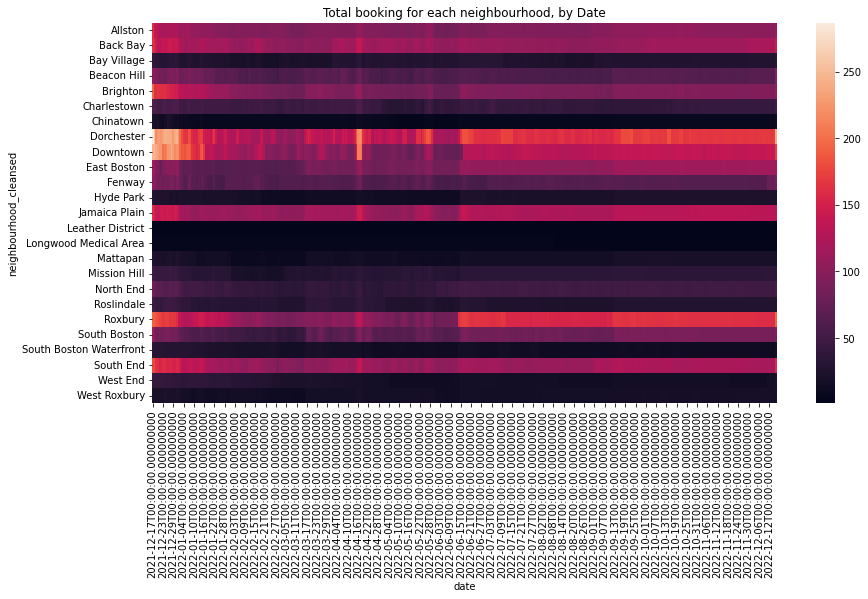

In [ ]:
#plot total booking by date by each neighbourhood
plt.figure(figsize=(14,7))
plt.title('Total booking for each neighbourhood, by Date')
sns.heatmap(data=temp_city_calendar_df.pivot('neighbourhood_cleansed', 'date', 'id_count'))
plt.ylabel('neighbourhood_cleansed')
plt.xlabel('date')

Text(0.5, 42.0, 'date')

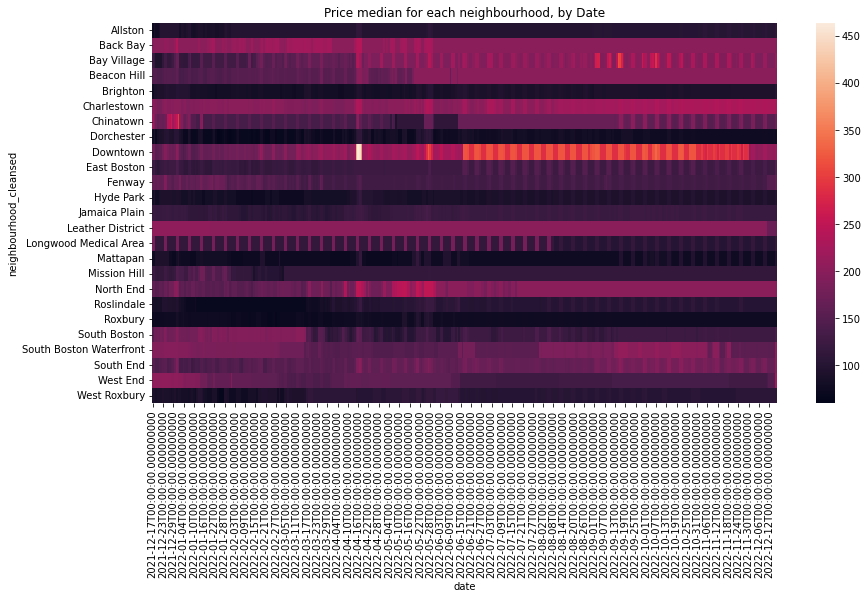

In [ ]:
#plot median price for each neighbourhood
plt.figure(figsize=(14,7))
plt.title('Price median for each neighbourhood, by Date')
sns.heatmap(data=temp_city_calendar_df.pivot('neighbourhood_cleansed', 'date', 'price_median'))
plt.ylabel('neighbourhood_cleansed')
plt.xlabel('date')

Text(0.5, 42.0, 'date')

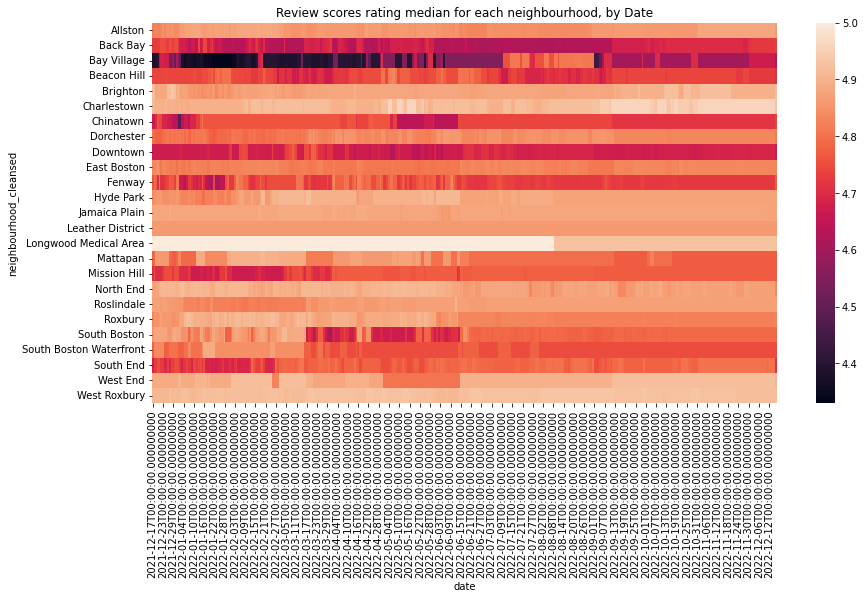

In [ ]:
#plot review score rating median for each neighbourhood
plt.figure(figsize=(14,7))
plt.title('Review scores rating median for each neighbourhood, by Date')
sns.heatmap(data=temp_city_calendar_df.pivot('neighbourhood_cleansed', 'date', 'review_scores_rating_median'))
plt.ylabel('neighbourhood_cleansed')
plt.xlabel('date')